In [1]:
import os 
import sys
import pickle 
import hyperspy.api as hs
sys.path.append("..")
import tomondt
from tomondt import Operator, Viewer, utils

import numpy as np
import torch 
import sys
import wandb

sys.path.append("..")

from tqdm import tqdm
from time import time

from dipster.solver import Solver
from dipster import alignments, tomo
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd


import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import shutil

path = r'\\ematbyname\emat\TimC\DIPSTER-PublicationData\Publication-Data'
dip_path = os.path.join(path, 'Dipster-recs')
vol_path = os.path.join(path, 'Volumes')
ts_path = os.path.join(path, 'TiltSeries')
rec_path = os.path.join(path, 'Reconstructions')
data_path =  os.path.join(path, 'Results')
asset_path =  os.path.join(path, 'Assets')

In [67]:
# Get Tomondt Images for DataSet 
sample_name = 'Cube-0'
voltype = 0 # 0 = reference, 1 = SIRT , 2 = DIPSTER
descriptor = None
folder = 'Static'
time_index = 0
slice_index = 256
axis  = 1

if descriptor is None:
    ts_name = sample_name
else:
    ts_name = sample_name +'-'+ descriptor 
    
match voltype:
    case 0:
        suffix = '-vol-'
        filename = os.path.join(vol_path, sample_name+'.vmf')
    case 1:
        suffix = '-rec-'
        filename = os.path.join(rec_path, folder, ts_name+'.vmf')
    case 2:
        suffix = '-dip-'
        for file in os.listdir(os.path.join(dip_path,folder)):
            if ts_name in file:
                filename = os.path.join(dip_path,folder, file)
    case _:
        raise ValueError('Invalid Volume Type')
    
vmf = tomondt.load_vmf(filename)
print(vmf.times[time_index])
viewer = tomondt.Viewer()
viewer.add_volume(vmf)
viewer.scale_bar.visible = True
viewer.dims.ndisplay=2
viewer.layers[0].colormap = 'gray'
match axis:
    case 0:
        viewer.dims.order = (0, 1, 2, 3)
        viewer.dims.current_step = (time_index, slice_index,0,0)
    case 1:
        viewer.dims.order = (0, 2, 1, 3)
        viewer.dims.current_step = (time_index, 0,slice_index,0)
    case 2:
        viewer.dims.order = (0, 3, 1, 2)
        viewer.dims.current_step = (time_index, 0,0,slice_index)
if not os.path.exists(os.path.join(asset_path, ts_name)):
    os.mkdir(os.path.join(asset_path, ts_name))
asset_file = os.path.join(os.path.join(asset_path, ts_name), ts_name+suffix+'-slice-'+str(slice_index)+'-time-'+str(time_index)+'-axis-'+str(axis)+'.png')
viewer.screenshot(asset_file)




0.0


array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0

In [1]:
# Measurement Cells for Publication Data
# Generates Temporal Figures = These are figures outlining the temporal evolution of the reconstruction for one sample at set time points
dipster_path = r'\\ematbyname\emat\TimC\DIPSTER-PublicationData\Publication-Data\Dipster-recs'
rec_path = r'\\ematbyname\emat\TimC\DIPSTER-PublicationData\Publication-Data\Reconstructions'
vol_path = r'\\ematbyname\emat\TimC\DIPSTER-PublicationData\Publication-Data\Volumes'
img_path = r'\\ematbyname\emat\TimC\DIPSTER-PublicationData\Publication-Data\Data Analysis'

# Sample Name and Settings Stuff you may need to change
sample_name = 'Rod-0'
measurement_times = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
optimum_window = '99'
axis = 0
dims = 128

# For Visual Effects
font = 'Arial'
fontsize = 10
img_size = 1 # inches
left_border =0.15

fig_width = (3 * img_size)
fig_width += left_border*fig_width # Here, 5 is the width of each image in inches, adjust as necessary
fig_height = img_size*len(measurement_times) # Here, 5 is the height of each image in inches, adjust as necessary
fig, ax = plt.subplots(nrows=len(measurement_times), ncols=3, figsize=(fig_width, fig_height))
fig.suptitle(sample_name, fontname=font, fontsize=fontsize)
col_titles = ['Reference', 'DIP-STER', 'mw-SIRT']

for i in range(3):
    ax[0,i].set_title(col_titles[i], fontname=font, fontsize=fontsize)



current_row = 0
sliceid = int(dims/2)

for i in range(3):
    if i ==0:
        fname = os.path.join(vol_path, sample_name+'.vmf')
    elif i == 1: 
        for filename in os.listdir(dipster_path):
            if sample_name in filename:
                fname = os.path.join(dipster_path, filename)
                break
    else:
        for filename in os.listdir(rec_path):
            if sample_name in filename and optimum_window in filename:
                fname = os.path.join(rec_path, filename)
                break
    vol = tomondt.load_vmf(fname)
    for j in range(len(measurement_times)):
        time = measurement_times[j]
        if np.isin(time, vol.times):
            image = vol.read_record(time)
            if image.shape[0] > dims:
                image = alignments.rebin(image, image.shape[0]/dims,True).astype(np.float32)
            if axis == 0:
                image = image[sliceid,:,:]  
                
            elif axis == 1:
                image = image[:,sliceid,:]
            else:
                image = image[:,:,sliceid]
        else:
            image = np.zeros((128,128)).astype(np.float32)
        
        ax[j,current_row].axis('off')
        ax[j,current_row].imshow(image, cmap='gray', aspect='auto')  # Using a grayscale colormap
        
    current_row += 1
    
    
plt.tight_layout() 
plt.subplots_adjust(left=left_border)  
plt.subplots_adjust(wspace=0.1, hspace=0)
for i in range(len(measurement_times)):
    bounds = ax[i, 0].get_position().bounds
    y_center = bounds[1] + bounds[3] / 2
    fig.text(0.04, y_center, measurement_times[i], va='center', fontname=font, fontsize=fontsize)
    


plt.savefig(os.path.join(img_path, sample_name +'-view-axis-'+str(axis)+'.png'), dpi=600)
plt.show() 


NameError: name 'plt' is not defined

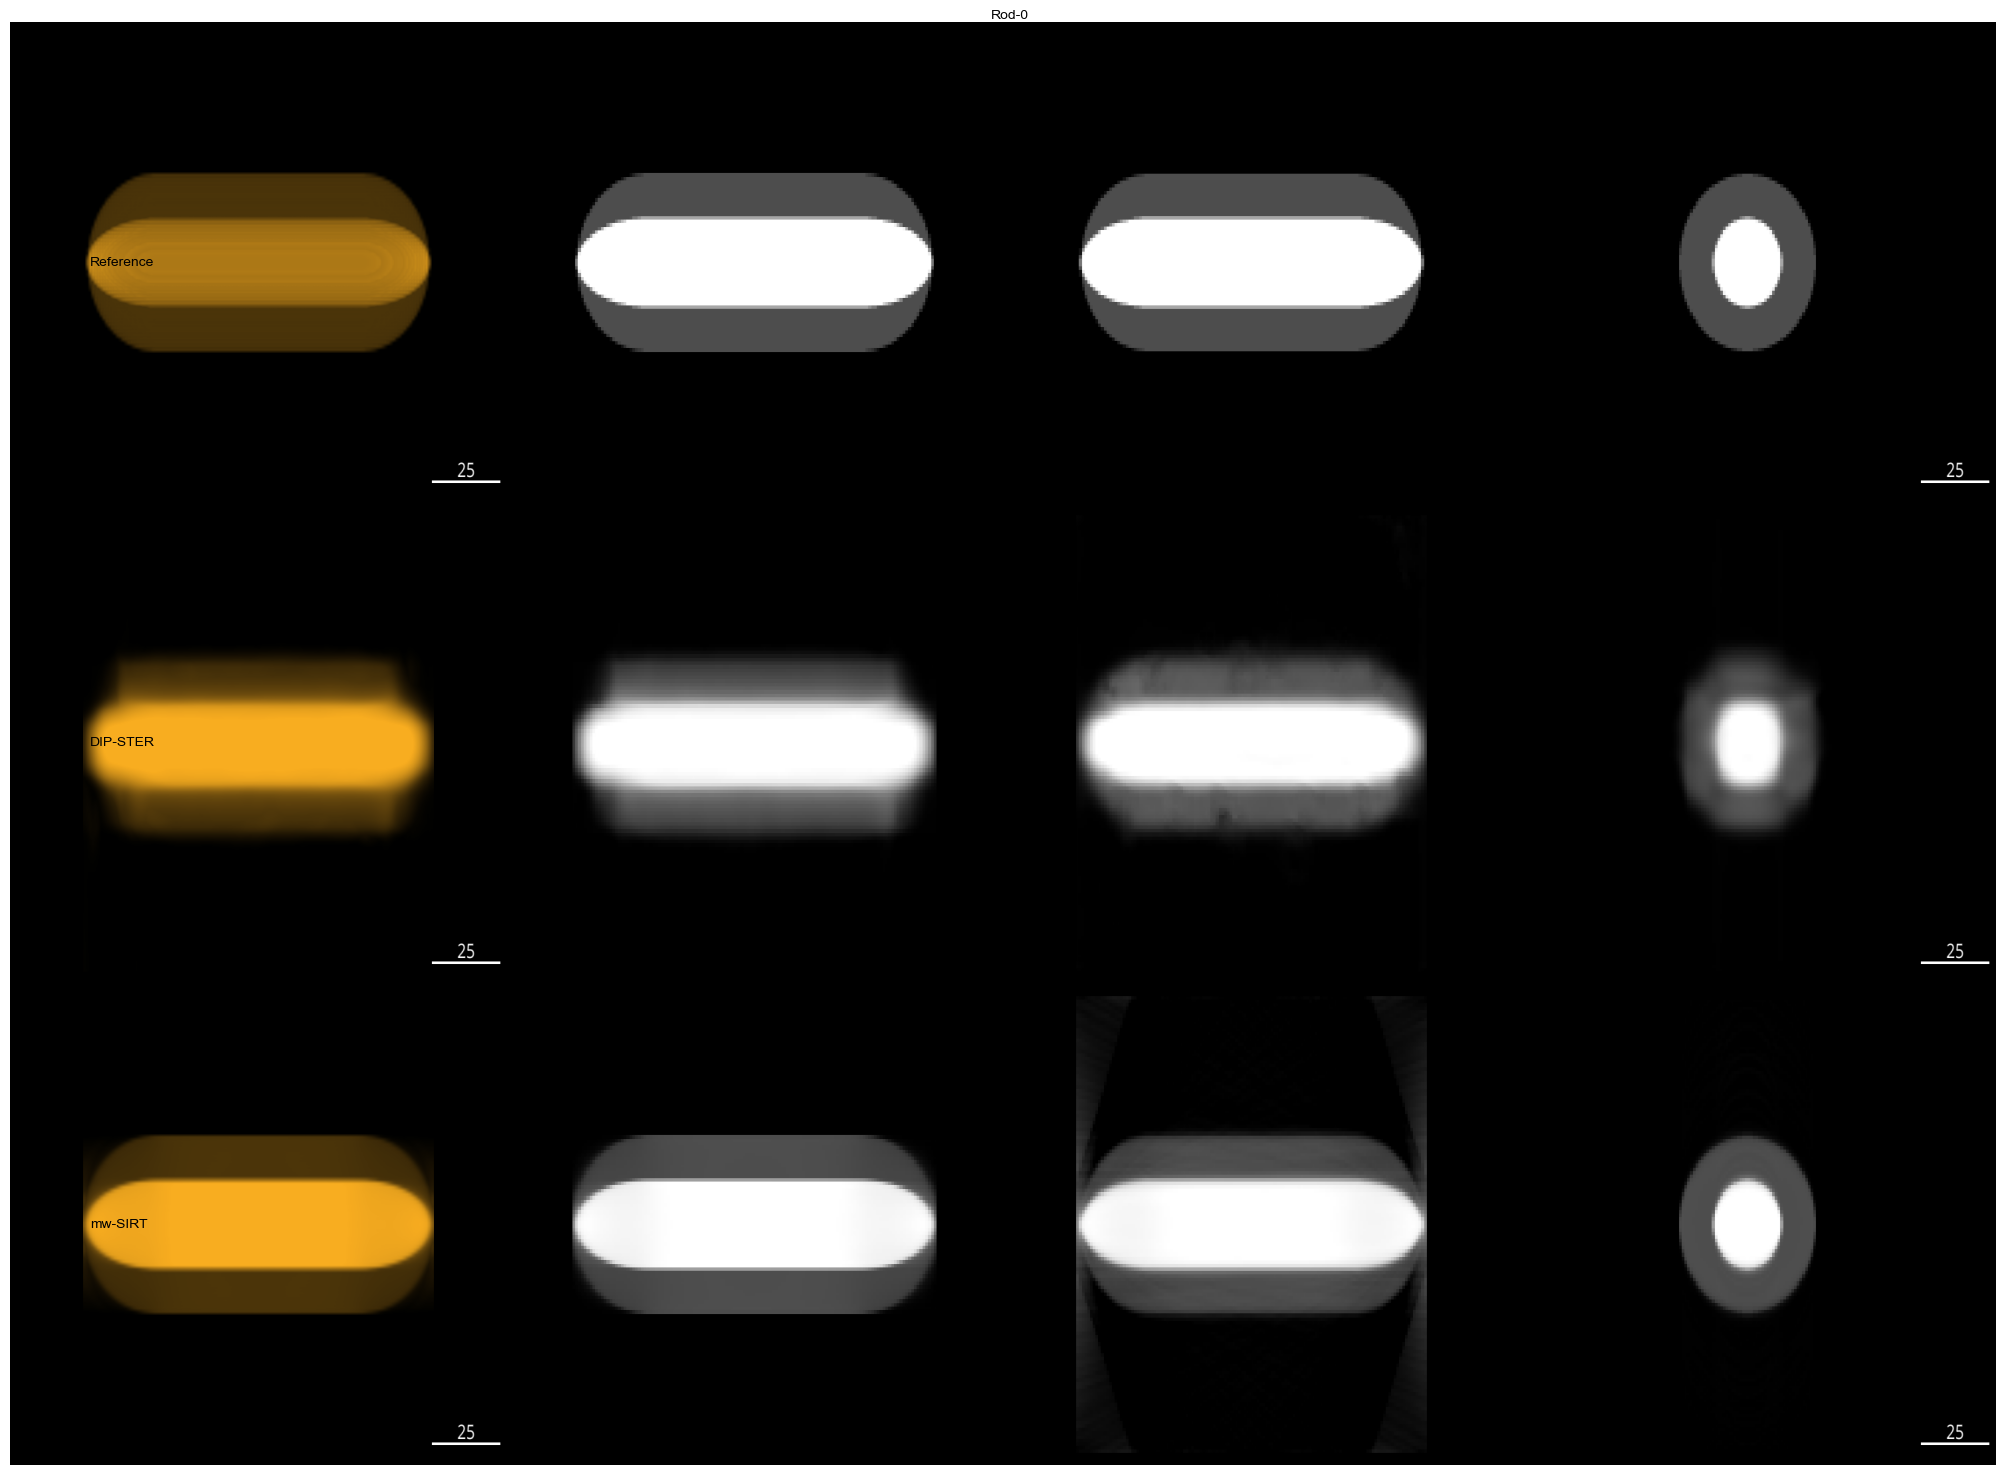

In [2]:
# This section is for generating the figure for static images

dipster_path = r'\\ematbyname\emat\TimC\DIPSTER-PublicationData\Publication-Data\Dipster-recs'
rec_path = r'\\ematbyname\emat\TimC\DIPSTER-PublicationData\Publication-Data\Reconstructions'
vol_path = r'\\ematbyname\emat\TimC\DIPSTER-PublicationData\Publication-Data\Volumes'
img_path = r'\\ematbyname\emat\TimC\DIPSTER-PublicationData\Publication-Data\Data Analysis'

viewer = tomondt.Viewer()
sample_name = 'Rod-0'
id  = '99'
sliceid_value = 64
temp_path = os.path.join(img_path,sample_name)
if not os.path.exists(temp_path):
    os.mkdir(temp_path)
paths = [[None] * 4 for _ in range(3)]
for filename in os.listdir(vol_path):
    if sample_name in filename and not 'reduced' in filename:
        fname = os.path.join(vol_path, filename)
        if not os.path.exists(os.path.join(vol_path, sample_name+'-reduced.vmf')):
            ref_origin = tomondt.load_vmf(fname)
            ref = tomondt.load_vmf(os.path.join(vol_path, sample_name+'-reduced.vmf'))
            for item in ref_origin.times:
                ref_data = ref_origin.read_record(item)
                ref_data = alignments.rebin(ref_data, 4, True)
                ref.write_record(ref_data, item)
        else:
            ref = tomondt.load_vmf(os.path.join(vol_path, sample_name+'-reduced.vmf'))
        break
for filename in os.listdir(dipster_path):
    if sample_name in filename:
        fname = os.path.join(dipster_path, filename)
        dipster = tomondt.load_vmf(fname)
        break
for filename in os.listdir(rec_path):
    if sample_name in filename and id in filename:
        fname = os.path.join(rec_path, filename)
        rec = tomondt.load_vmf(fname)
        break
recs = [ref, dipster, rec]
for i in range(3):
    viewer.add_volume(recs[i])
    viewer.layers[i].visible = False
  
#viewer.camera.zoom = 2  
for i in range(3):
    viewer.dims.ndisplay=3
    viewer.layers[i].colormap = 'bop orange'
    viewer.layers[i].visible = True
    paths[i][0] = os.path.join(temp_path, sample_name +str(i)+'-vol.png')
    viewer.screenshot(paths[i][0])
    viewer.layers[i].visible = False
    
for i in range(3):
    viewer.scale_bar.visible = False
    viewer.layers[i].visible = True
    viewer.dims.ndisplay=2
    viewer.layers[i].colormap = 'gray'
    viewer.dims.current_step = (sliceid_value,0,0)
    paths[i][1] = os.path.join(temp_path, sample_name +str(i)+'-ortho1.png')
    viewer.screenshot(paths[i][1])
    viewer.layers[i].visible = False
    
for i in range(3):
    viewer.layers[i].visible = True
    viewer.dims.ndisplay=2
    viewer.layers[i].colormap = 'gray'
    viewer.dims.order = (1, 0, 2)
    viewer.dims.current_step = (0,sliceid_value,0)
    paths[i][2] = os.path.join(temp_path, sample_name +str(i)+'-ortho2.png')
    viewer.screenshot(paths[i][2])
    viewer.dims.order = (1, 0, 2)
    viewer.layers[i].visible = False
    
for i in range(3):
    viewer.scale_bar.visible = True
    viewer.layers[i].visible = True
    viewer.dims.ndisplay=2
    viewer.layers[i].colormap = 'gray'
    viewer.dims.order = (2, 0, 1)
    viewer.dims.current_step = (0,0,sliceid_value)
    paths[i][3] = os.path.join(temp_path, sample_name +str(i)+'-ortho3.png')
    viewer.screenshot(paths[i][3])
    viewer.dims.order = (1, 2, 0)
    viewer.layers[i].visible = False

font = 'Arial'
fontsize = 10
img_size = 5 # inches
left_border =0
row_titles = ['Reference', 'DIP-STER', 'mw-SIRT']

fig_width = (4 * img_size)
fig_width += left_border*fig_width # Here, 5 is the width of each image in inches, adjust as necessary
fig_height = img_size*3 # Here, 5 is the height of each image in inches, adjust as necessary
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(fig_width, fig_height))
fig.suptitle(sample_name, fontname=font, fontsize=fontsize)

for i in range(3):
    for j in range(4):
        ax[i,j].axis('off')
        ax[i,j].imshow(Image.open(paths[i][j]), aspect='auto')
        
        
plt.tight_layout() 
plt.subplots_adjust(left=left_border)  
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(3):
    bounds = ax[i, 0].get_position().bounds
    y_center = bounds[1] + bounds[3] / 2
    fig.text(0.04, y_center, row_titles[i], va='center', fontname=font, fontsize=fontsize)
    


plt.savefig(os.path.join(img_path, sample_name +'summary'+'.png'), dpi=600)
plt.show()         
